Here we will try to do some creation of a vector field from the brushstrokes generated in the last image.

Firstly we want to expand each brushstroke so that they fill the frame. We can do this with a morphological transform. We will follow a fairly basic process:
1. Fill a frame with ones, call this A
2. Iterate over each brushstroke, growing it slightly
3. Elementwise multiply it by the matrix A.
4. Subtract this from A. Over time A will represent the area which is not assigned to a brushtroke.

In [1]:
import cv2
import scipy.stats.qmc as qmc
import scipy
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from collections import Counter
import random

In [2]:
#INTERACTIVE ELEMENTS
assigned_dict = {}

In [3]:
with open('../out/m.pkl', 'rb') as inp:
    gradients = pickle.load(inp)
with open('../out/strokes.pkl', 'rb') as inp:
    brushstrokes = pickle.load(inp)
sz = np.shape(brushstrokes[0])
numbrush = len(brushstrokes)
thetas = np.arctan(gradients)
im = cv2.imread('../res/starry_night_crop.jpg')
im = cv2.colorChange(im, None, cv2.COLOR_RGB2BGR)

In [4]:
kernel = np.ones([3,3], np.uint8)
brushstrokes_dilated = brushstrokes.copy()
indices = list(range(numbrush))
A = np.ones(sz, np.uint8)
# First pass - remove current brushstrokes from A
for i in range(numbrush):
    A = A-brushstrokes[i]

while len(indices) > 0:
    for i in range(len(indices)-1,-1,-1):
        
        idx = indices[i]
        dilated = cv2.dilate(np.uint8(brushstrokes_dilated[idx]), kernel)
        check_idx = 65
        # if (idx==check_idx):

            # plt.subplot(1,4,1)
            # plt.imshow(dilated)
        dilated = dilated * A + brushstrokes_dilated[idx]
        # if (idx==check_idx):
            # plt.subplot(1,4,2)
            # plt.imshow(dilated)
        if (np.sum(dilated) == np.sum(brushstrokes_dilated[idx])):
            indices.pop(i)
            break
        else:
            brushstrokes_dilated[idx] = dilated
            A = A - dilated*A
        # if (idx==check_idx):
            # print("C",np.sum(brushstrokes[idx]),",", np.sum(brushstrokes_dilated[idx]))
            # plt.subplot(1,4,3)
            # plt.imshow(brushstrokes_dilated[idx])
            # plt.subplot(1,4,4)
            # plt.imshow(A)
            # plt.show()


Next we want to identify every brushstroke's three nearest neighbours. We can do this by dilating each brushstroke by one pixel, multiplying a matrix containing each brushstroke's index by this dilated pixel, and identifying each item in that appears in that matrix.

In [5]:
k = 5


vector_of_xmeans = np.zeros([1,numbrush])
vector_of_ymeans = np.zeros([1,numbrush])
a = np.ones([sz[0],1])
b = np.array([range(sz[1])])
x_ordinates = np.reshape(a @ b, sz[0]*sz[1])

a = np.array([range(sz[1])]).T
b = np.ones([sz[0],1]).T
y_ordinates =  np.reshape(a @ b, sz[0]*sz[1])
for i in range(numbrush):
    x_ords_brush = np.reshape(np.bool8(brushstrokes[i]), sz[0]*sz[1])
    x_ords_brush = x_ordinates[x_ords_brush]
    x_mean = np.mean(x_ords_brush)
    vector_of_xmeans[0,i] = x_mean

    y_ords_brush = np.reshape(np.bool8(brushstrokes[i]), sz[0]*sz[1])
    y_ords_brush = y_ordinates[y_ords_brush]
    y_mean = np.mean(y_ords_brush)
    vector_of_ymeans[0,i] = y_mean
matrix_of_xmeans = np.ones([numbrush,1]) @ vector_of_xmeans
matrix_of_ymeans = np.ones([numbrush,1]) @ vector_of_ymeans

matrix_of_xdist = matrix_of_xmeans - matrix_of_xmeans.T
matrix_of_ydist = matrix_of_ymeans - matrix_of_ymeans.T
matrix_of_dist_sq = matrix_of_xdist * matrix_of_xdist + matrix_of_ydist * matrix_of_ydist
matrix_of_dist = np.sqrt(matrix_of_dist_sq)


In [6]:
def get_polarity_probability(region_index, polarities):
    probability = 0
    # indxes = np.array([neighbour_1[region_index], neighbour_2[region_index], neighbour_3[region_index]], np.int64)
    # indxes = neighbours[region_index,:]
    indxes = np.argsort(matrix_of_dist[region_index])[1:k+1]
    for idx in indxes:
        if ((idx != -1) and (polarities[idx] != 0)):
            dtheta = (thetas[region_index]-thetas[idx]+np.pi/2)%np.pi-np.pi/2
            p = np.cos(dtheta)
            sign_applied = 1
            mean_theta_abs = (abs(thetas[region_index])+abs(thetas[idx]))/2
            if mean_theta_abs < np.pi / 4:
                sign_applied = np.sign(thetas[region_index]) * np.sign(thetas[idx])
            if (np.abs(probability) ==0):
                probability = p * polarities[idx]*sign_applied
    return probability

def get_probability_vector(polarities):
    theta_mat = np.ones([numbrush,1])@np.array([thetas])
    dtheta_mat = (theta_mat-theta_mat.T+np.pi/2)%np.pi-np.pi/2
    angle_factor = np.cos(dtheta_mat)
    mean_theta_abs = (np.abs(theta_mat)+np.abs(theta_mat.T))/2
    mask_sign = np.bool8(mean_theta_abs < np.pi/4)
    sign_matrix = np.zeros([numbrush,numbrush])
    sign_matrix[mask_sign] = (np.sign(theta_mat)*np.sign(theta_mat.T))[mask_sign]
    sign_matrix[np.bool8(1-mask_sign)] = 1
    polarities_factor = np.ones([numbrush,1])@np.array([polarities])
    matrix_of_dist_sq_zero_diag = matrix_of_dist_sq
    matrix_of_dist_sq_zero_diag[np.bool8(np.eye(numbrush, numbrush))] = np.inf
    probability_matrix = angle_factor * sign_matrix / matrix_of_dist_sq_zero_diag *polarities_factor
    probability_vector = np.sum(probability_matrix, axis = 1)
    mask_already_assigned = np.bool8(polarities!=0)
    probability_vector[mask_already_assigned] = 0
    return (probability_vector)

        

In [7]:
aspect_ratio = sz[1]/sz[0]
coordinates_x = np.ones([sz[0],1]) @ np.array([range(sz[1])])*aspect_ratio/sz[1]
coordinates_y = (np.array([range(sz[0])])/sz[0]).T * np.ones([1,sz[1]])
wavenumbers_1d_x = np.int64(np.array([np.fft.fftfreq(sz[1]) * sz[1]]))
n_fft_points_x = wavenumbers_1d_x.shape[1]
wavenumbers_1d_y = np.int64(np.array([np.fft.fftfreq(sz[0]) * sz[0]]))
n_fft_points_y = wavenumbers_1d_y.shape[1]
wavenumbers_x = np.ones([n_fft_points_y,1]) @ wavenumbers_1d_x
wavenumbers_y = wavenumbers_1d_y.T @ np.ones([1,n_fft_points_x])
w_x_w_y = wavenumbers_x*wavenumbers_x+wavenumbers_y*wavenumbers_y
k = 0.1
flter = np.exp(-k*w_x_w_y)

def get_U_V(polarity):
    U = np.zeros(sz)
    V = np.zeros(sz)
    # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
    for i in range(numbrush):
        V += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])
        U += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]
    U_fft = np.fft.fft2(U)
    V_fft = np.fft.fft2(V)
    U_fft *= flter
    V_fft *= flter
    U = np.fft.ifft2(U_fft, sz)
    V = np.fft.ifft2(V_fft, sz)
    return(U,V)

def curl_fft(polarity):
    U = np.zeros(sz)
    V = np.zeros(sz)
    # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
    for i in range(numbrush):
        V += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])
        U += brushstrokes_dilated[i]*polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]
    
    return curl_fft_UV(U,V)
def curl_fft_UV(U,V):
    d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
    d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
    curl_fft = d_v_d_x_fft - d_u_d_y_fft
    curl_fft *= flter
    return curl_fft
def curl_image(curl_fft, best_polarity):
    
    brush_directions = np.zeros(sz)
    # plt.subplot(1,2,1)
    # plt.imshow(im)
    im_show = im.copy()
    border_mask = np.zeros(sz)
    plt.subplot(1,2,2)
    # plt.imshow(im)

    for i in range(numbrush):
        brush_directions += cv2.erode(brushstrokes_dilated[i], np.ones([2,2]))
        sf = 20
        magnitude = np.sqrt(1+1/gradients[i]/gradients[i])
        a = cv2.erode(brushstrokes[i],np.array([[1,1,1],[1,1,1],[1,1,1]]))
        b = brushstrokes[i]-a
        border_mask += b
        plt.arrow(vector_of_xmeans[0,i], vector_of_ymeans[0,i], sf/magnitude/gradients[i]*best_polarity[i], sf/magnitude*best_polarity[i], head_width = 10)
        col = (0,0,255)
        if i in assigned_dict:
            if assigned_dict[i] == 1:
                col = (0,255,0)
            else:
                col = (255,0,0)
        im_show = cv2.arrowedLine(im_show, (np.int32(vector_of_xmeans[0,i]), np.int32(vector_of_ymeans[0,i])),(np.int32(vector_of_xmeans[0,i] + sf/magnitude/gradients[i]*best_polarity[i]), np.int32(vector_of_ymeans[0,i] + sf/magnitude*best_polarity[i])), col, 1, cv2.LINE_AA, tipLength = 0.5)
    im_show[np.bool8(border_mask),:] = 0
    plt.imshow(im_show)

    # print(curl_fft.shape)
    curl = np.fft.ifft2(curl_fft, sz)
    curl = np.real(curl)
    plt.subplot(1,2,1)
    plt.imshow(curl)
    plt.show()
    return im_show



In [8]:

polarities = np.zeros([numbrush])
random.seed(1)
def onClick(event, x, y, flags, param):
    # Check if the left mouse button was clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        distance = np.sqrt((x-vector_of_xmeans)**2+(y-vector_of_ymeans)**2)
        index = np.argmin(distance)
        if index in assigned_dict:
            assigned_dict[index] = -assigned_dict[index]
        else:
            assigned_dict[index] = -1
        print(f"Clicked at position ({x}, {y})")
def get_polarity_option(polarities):
    cv2.namedWindow("Strokes")
    cv2.setMouseCallback("Strokes", onClick)
    loop = True
    while loop:
        polarities = np.zeros([numbrush])
        valid = True
        #1: If the dictionary is empty, then randomly assign a polarity
        print(assigned_dict)
        if assigned_dict == {}:
            ran_brush = random.randint(0,numbrush-1)
            polarities[ran_brush] = np.sign(random.random()-0.5)
        #2: Else assign the polarity based on the dictionary
        for key in assigned_dict:
            polarities[key] = assigned_dict[key]

        while 0 in polarities:
            probabilities = get_probability_vector(polarities)
            
            index_to_change = np.argmax(np.abs(probabilities))
            polarities[index_to_change] = np.sign(probabilities[index_to_change])

        img = curl_image(curl_fft(polarities), polarities)
        cv2.imshow("Strokes", img)
        # Wait for user input (e.g. a key press)
        key = cv2.waitKey(0)
        if key == 48:
            loop = False
        
    return polarities


{}


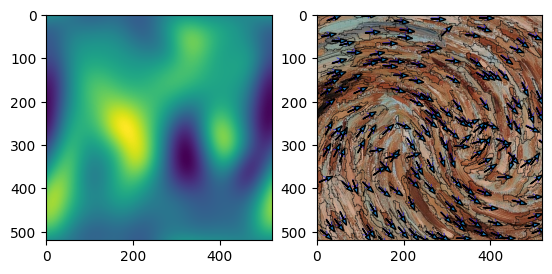

Clicked at position (83, 383)
{3: -1}


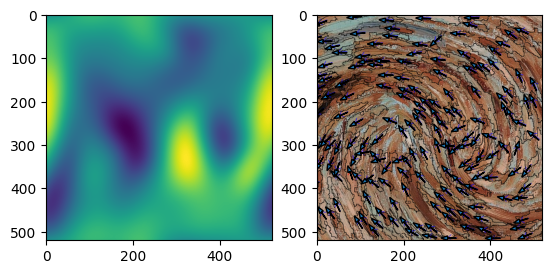

Clicked at position (84, 382)
{3: 1}


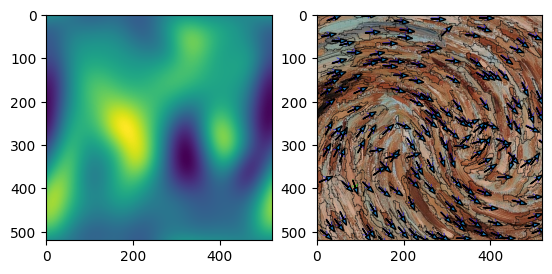

Clicked at position (52, 341)
{3: 1, 110: -1}


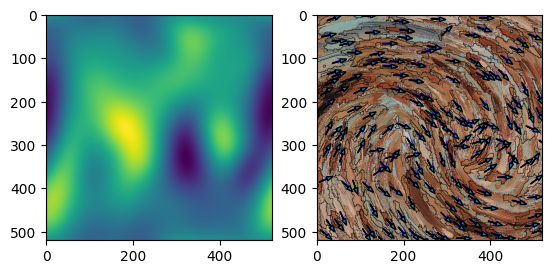

Clicked at position (52, 341)
{3: 1, 110: 1}


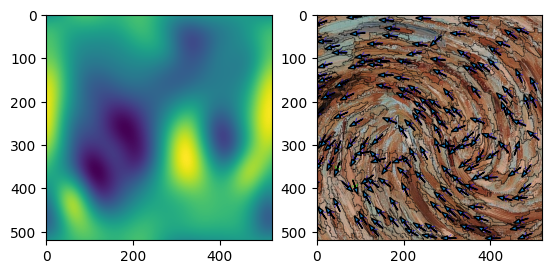

Clicked at position (52, 341)
{3: 1, 110: -1}


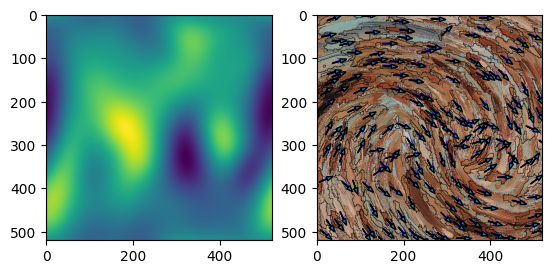

Clicked at position (52, 341)
{3: 1, 110: 1}


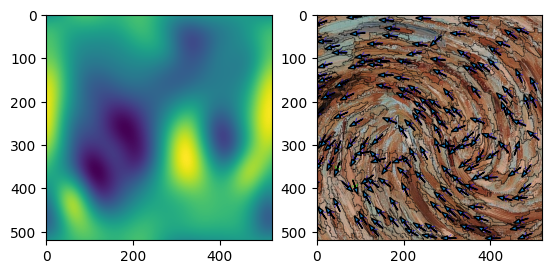

Clicked at position (123, 435)
Clicked at position (123, 435)
{3: 1, 110: 1, 67: 1}


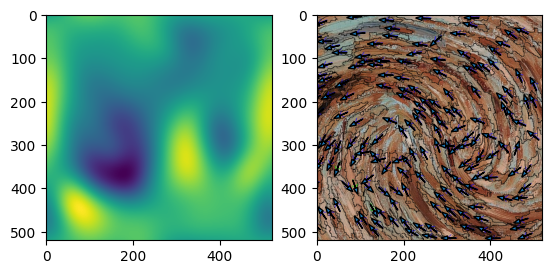

Clicked at position (159, 472)
Clicked at position (159, 472)
Clicked at position (115, 486)
Clicked at position (115, 486)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1}


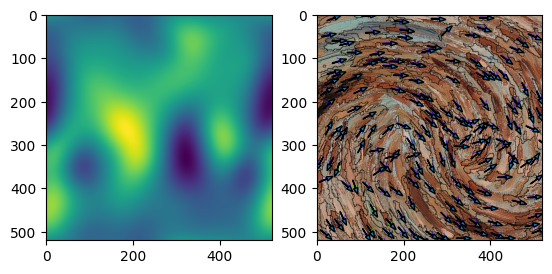

Clicked at position (5, 386)
Clicked at position (5, 386)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1}


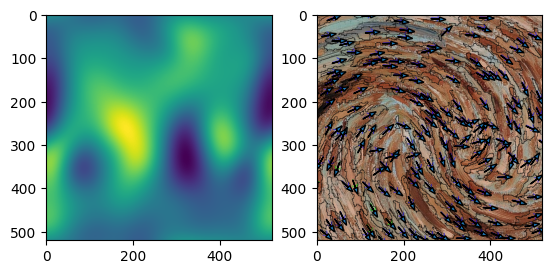

Clicked at position (210, 419)
Clicked at position (210, 419)
Clicked at position (251, 499)
Clicked at position (251, 499)
Clicked at position (209, 376)
Clicked at position (209, 376)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1}


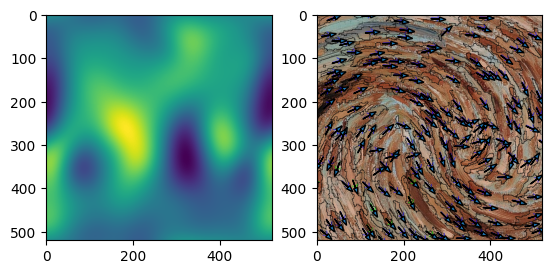

Clicked at position (130, 369)
Clicked at position (130, 369)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1}


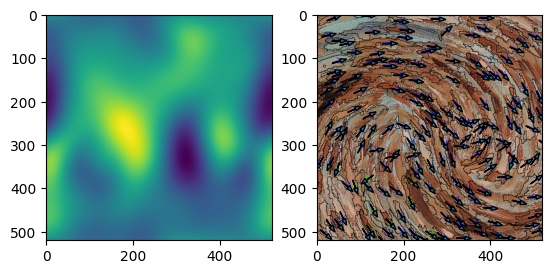

Clicked at position (94, 318)
Clicked at position (94, 318)
Clicked at position (118, 284)
Clicked at position (118, 284)
Clicked at position (152, 279)
Clicked at position (152, 279)
Clicked at position (185, 250)
Clicked at position (185, 250)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: 1}


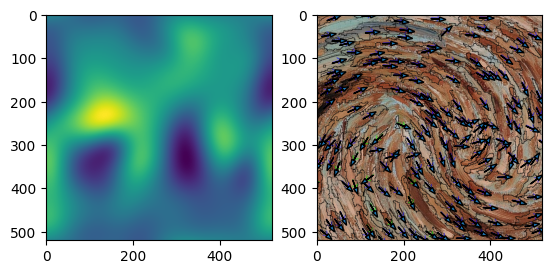

Clicked at position (184, 250)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1}


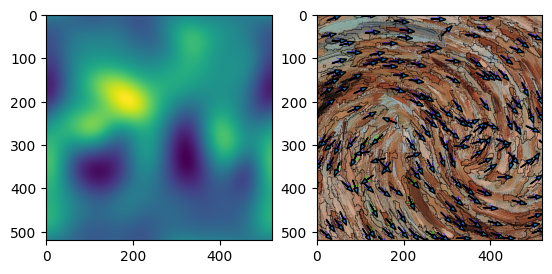

Clicked at position (250, 386)
Clicked at position (217, 352)
Clicked at position (230, 339)
Clicked at position (296, 434)
Clicked at position (320, 465)
Clicked at position (353, 469)
Clicked at position (402, 504)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1}


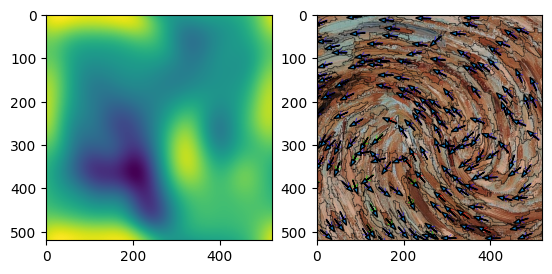

Clicked at position (286, 457)
Clicked at position (286, 457)
Clicked at position (317, 478)
Clicked at position (317, 478)
Clicked at position (363, 499)
Clicked at position (363, 499)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1}


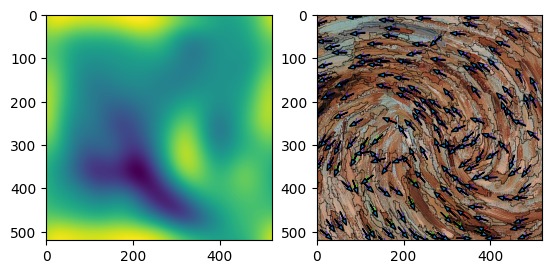

Clicked at position (442, 318)
Clicked at position (442, 318)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1}


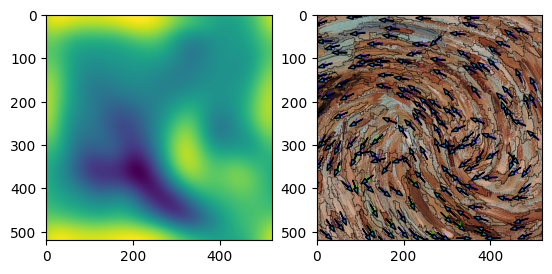

Clicked at position (512, 290)
Clicked at position (512, 290)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1}


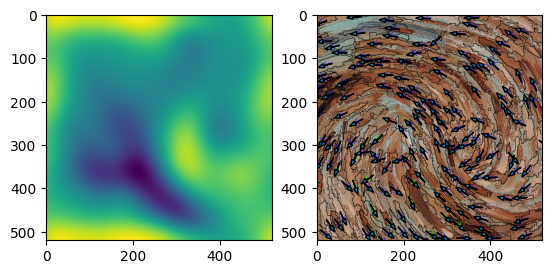

Clicked at position (481, 256)
Clicked at position (481, 256)
Clicked at position (454, 244)
Clicked at position (454, 244)
Clicked at position (438, 233)
Clicked at position (438, 233)
Clicked at position (377, 192)
Clicked at position (377, 192)
Clicked at position (298, 144)
Clicked at position (298, 144)
Clicked at position (215, 111)
Clicked at position (215, 111)
Clicked at position (166, 108)
Clicked at position (166, 108)
Clicked at position (168, 110)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: -1}


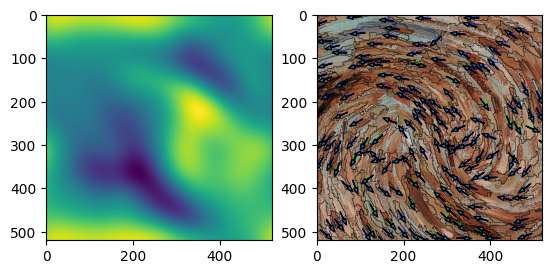

Clicked at position (168, 110)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1}


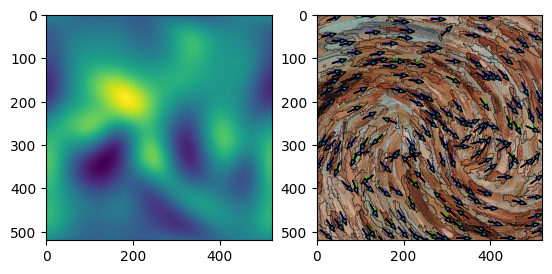

Clicked at position (86, 183)
Clicked at position (86, 183)
Clicked at position (220, 183)
Clicked at position (240, 183)
Clicked at position (170, 171)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1}


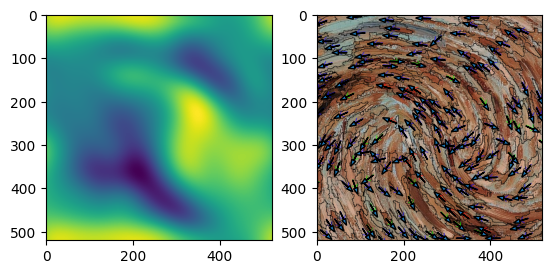

Clicked at position (152, 117)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1}


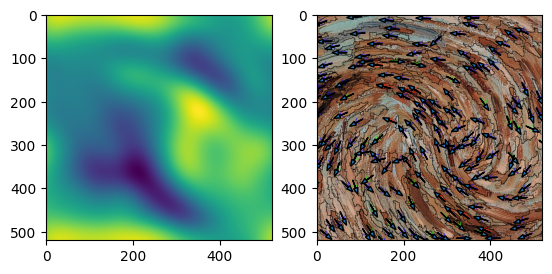

Clicked at position (296, 106)
Clicked at position (296, 106)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1}


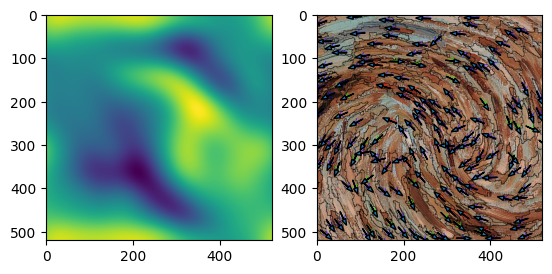

Clicked at position (367, 135)
Clicked at position (367, 135)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1}


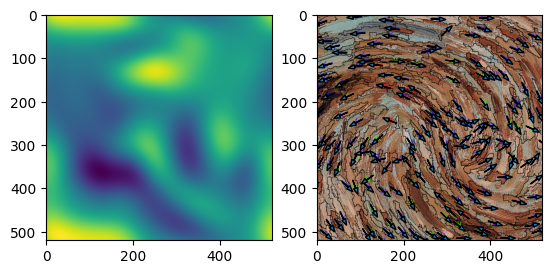

Clicked at position (287, 215)
Clicked at position (262, 215)
Clicked at position (210, 194)
Clicked at position (252, 237)
Clicked at position (284, 283)
Clicked at position (302, 263)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1}


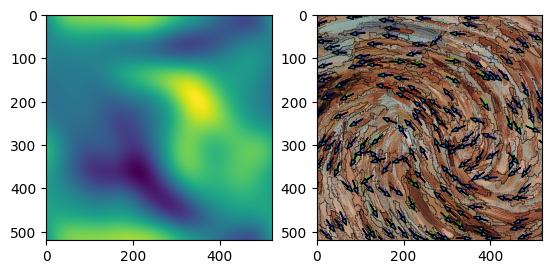

Clicked at position (129, 106)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1}


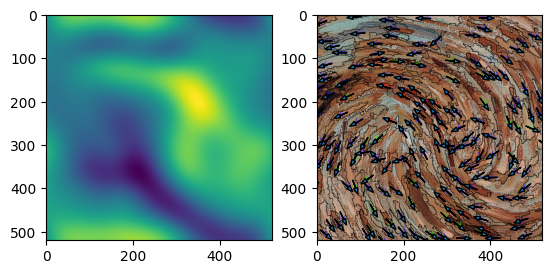

Clicked at position (106, 115)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1}


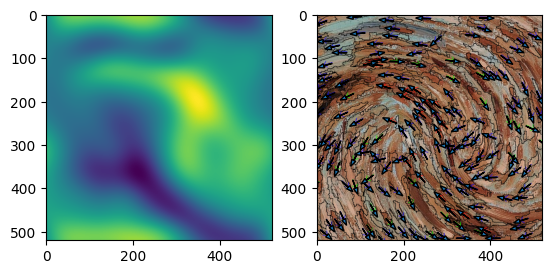

Clicked at position (23, 137)
Clicked at position (35, 144)
Clicked at position (35, 144)
Clicked at position (73, 152)
Clicked at position (73, 152)
Clicked at position (17, 166)
Clicked at position (17, 166)
Clicked at position (42, 182)
Clicked at position (42, 182)
Clicked at position (53, 72)
Clicked at position (112, 43)
Clicked at position (189, 36)
Clicked at position (189, 36)
Clicked at position (189, 36)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: -1, 17: -1, 42: -1}


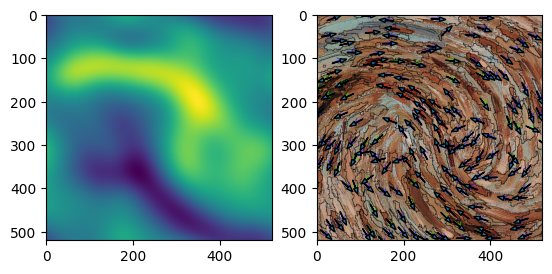

Clicked at position (110, 42)
Clicked at position (52, 74)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: 1, 17: 1, 42: -1}


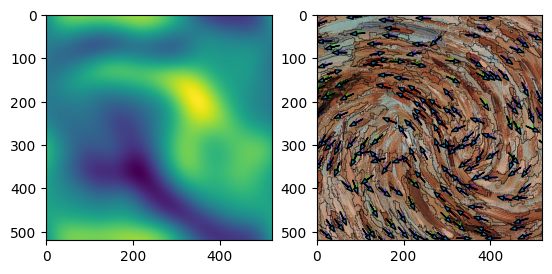

Clicked at position (55, 72)
Clicked at position (111, 42)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: -1, 17: -1, 42: -1}


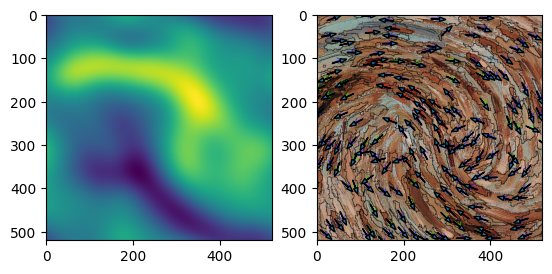

Clicked at position (186, 52)
Clicked at position (186, 52)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: -1, 17: -1, 42: -1, 73: 1}


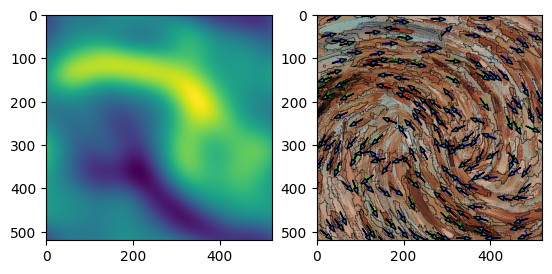

Clicked at position (191, 34)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: -1, 17: -1, 42: 1, 73: 1}


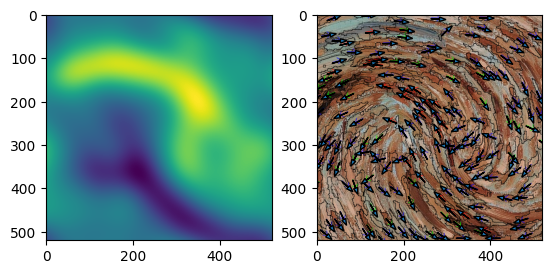

Clicked at position (148, 342)
Clicked at position (148, 342)
{3: 1, 110: 1, 67: 1, 86: 1, 53: 1, 69: 1, 32: 1, 101: 1, 126: 1, 111: 1, 54: 1, 35: 1, 140: 1, 142: -1, 78: -1, 99: -1, 59: -1, 92: -1, 143: -1, 38: -1, 85: -1, 8: 1, 158: 1, 62: 1, 100: 1, 68: 1, 13: 1, 119: 1, 105: 1, 0: 1, 30: 1, 117: 1, 81: 1, 16: 1, 104: -1, 116: -1, 48: -1, 108: -1, 6: 1, 65: 1, 25: -1, 134: -1, 107: -1, 75: -1, 148: -1, 95: -1, 151: -1, 128: -1, 150: -1, 112: 1, 125: 1, 50: 1, 31: 1, 27: -1, 17: -1, 42: 1, 73: 1, 97: 1}


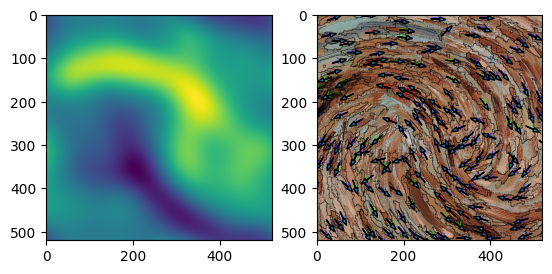

In [9]:
ps = get_polarity_option(polarities)

# Promising?

# Attempt 2 - Using Vorticity

So far the brushstroke allocation has no measure for how successful the application is based on the resulting flow. We could easily create a function which measures the resulting vorticity. Comparing the random brushstroke allocation to the improved one, we see that the better vorticity pattern has a higher total power since less of it is carried in the high frequency domain which gets blurred.

In [10]:
#Function to tell us the total power captured by a vortex field.
def total_power(curl_fft):
    PSD = curl_fft*np.conj(curl_fft)
    return (np.real(np.sum(PSD)), PSD)

In [11]:
#Test the theory - is the total power of the vortex field above higher than that of the random distribution?
U_random = np.zeros(sz)
V_random = np.zeros(sz)
# best_polarity = np.sign(np.random.rand(numbrush)-0.5)
for i in range(numbrush):
    random_polarity = np.sign(random.random()-0.5)
    V_random += brushstrokes_dilated[i]*random_polarity/np.sqrt(1+1/gradients[i]/gradients[i])
    U_random += brushstrokes_dilated[i]*random_polarity/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]

d_u_d_y_fft_random = 1j * wavenumbers_y * np.fft.fft2(U_random)
d_v_d_x_fft_random = 1j * wavenumbers_x * np.fft.fft2(V_random)
curl_fft_random = d_v_d_x_fft_random - d_u_d_y_fft_random
curl_fft_random *= flter

total_power_assigned = total_power(curl_fft(best_polarity))[0]
total_power_random = total_power(curl_fft_random)[0]
print("Assigned", total_power_assigned)
print("Random", total_power_random)
print("Ratio (Assigned/Random)",total_power_assigned/total_power_random)

NameError: name 'best_polarity' is not defined

In [ ]:
def vorticity_polarity_options():
    opts = np.zeros([num_polarity_options, numbrush])
    for i in range(num_polarity_options):
        opt_valid = False
        while opt_valid == False:
            opt = get_polarity_option()
            opt_valid = opt[0]
            opt = opt[1]
        if (i!=0):
            running_best = np.mean(opts, axis=0)
            diff_pos = running_best - opt
            diff_neg = running_best + opt
            if (np.abs(np.sum(diff_neg)) < np.abs(np.sum(diff_pos))):
                opt *= -1
        opts[i,:] = opt
    powers = np.zeros([num_polarity_options])
    for i in range(num_polarity_options):
        U = np.zeros(sz)
        V = np.zeros(sz)
        # best_polarity = np.sign(np.random.rand(numbrush)-0.5)
        for j in range(numbrush):
            V += brushstrokes_dilated[j]*opts[i,j]/np.sqrt(1+1/gradients[j]/gradients[j])
            U += brushstrokes_dilated[j]*opts[i,j]/np.sqrt(1+1/gradients[j]/gradients[j])/gradients[j]

        d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
        d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
        curl_fft = d_v_d_x_fft - d_u_d_y_fft
        curl_fft *= flter
        powers[i] = total_power(curl_fft)[0]
    return (opts,powers)

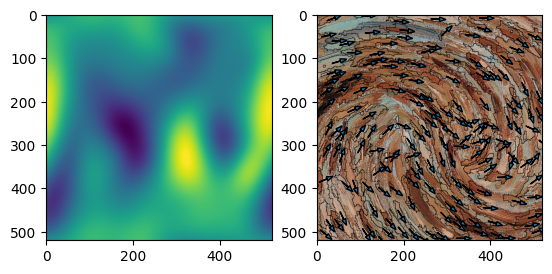

In [ ]:
opts_powers = vorticity_polarity_options()
best_polarity_vorticity = np.sign(np.sum(opts_powers[0]*np.array([opts_powers[1]]).T/np.sum(opts_powers[1]),axis=0))
curl_diagram(curl_fft(best_polarity_vorticity))

In [13]:
with open('../out/polarities.pkl', 'wb') as outp:
    pickle.dump(ps, outp, pickle.HIGHEST_PROTOCOL)
U_V = get_U_V(ps)
with open('../out/U.pkl', 'wb') as outp:
    pickle.dump(U_V[0], outp, pickle.HIGHEST_PROTOCOL)
with open('../out/V.pkl', 'wb') as outp:
    pickle.dump(U_V[1], outp, pickle.HIGHEST_PROTOCOL)